<a href="https://colab.research.google.com/github/jceltruda/FinGPT-TransformerPrediction/blob/Dash/Fine_tune2_predictL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
!pip install transformers

In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='djia_stock_data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='djia_stock_data.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
{"note": "note-for-model-to-predict"}
{"note": "note-for-model-to-predict-1"}
{"note": "note-for-model-to-predict-2"}

{'note': 'note-for-model-to-predict-2'}

In [5]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.ca

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

994


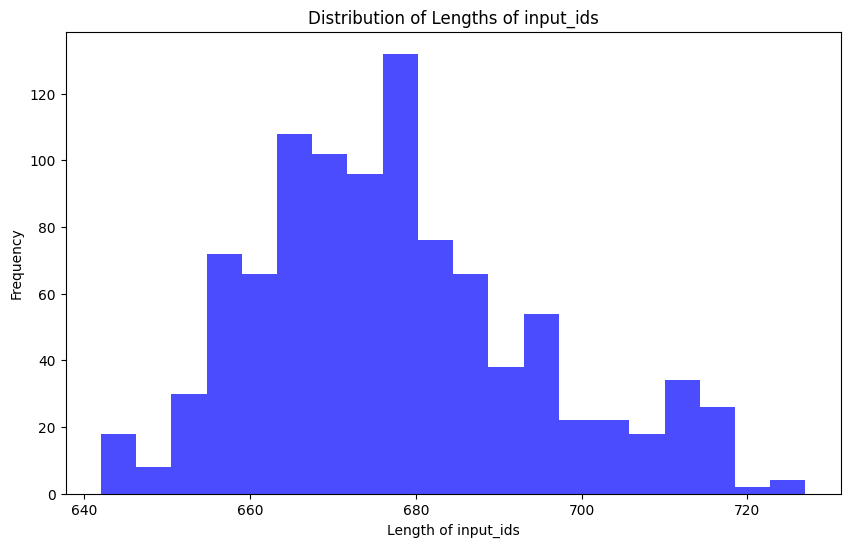

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
 Hinweis: Die folgende Liste ist nicht vollständig.

##

In [11]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 835, 894, 29901, 28794, 2630, 1041, 363, 3517, 29871, 29953, 3841, 29901, 12742, 29871, 29896, 29901, 4673, 29901, 29941, 29896, 29929, 29945, 29945, 29889, 29929, 29941, 29929, 29946, 29945, 29941, 29896, 29906, 29945, 5057, 29901, 29941, 29896, 29929, 29947, 29946, 29889, 29955, 29953, 29929, 29945, 29941, 29896, 29906, 29945, 17511, 29901, 29941, 29896, 29906, 29929, 29941, 29889, 29941, 29906, 29900, 29941, 29896, 29906, 29945, 23186, 29901, 29941, 29896, 29946, 29900, 29906, 29889, 29900, 29900, 29929, 29955, 29953, 29945, 29953, 29906, 29945, 2087, 29926, 23186, 29901, 29941, 29896, 29946, 29900, 29906, 29889, 29900, 29900, 29929, 29955, 29953, 29945, 29953, 29906, 29945, 16934, 29901, 29946, 29945, 29946, 29896, 29896, 29900, 29900, 29900, 29900, 29892, 8373, 29871, 29906, 29901, 4673, 29901, 29941, 29896, 29946, 29900, 29896, 29889, 29906, 29947, 29929, 29900, 29953, 29906, 29945, 5057, 29901, 29941, 29896, 29946, 29945, 29900, 29889, 29947, 29929, 29900, 29953, 29906, 2994

994


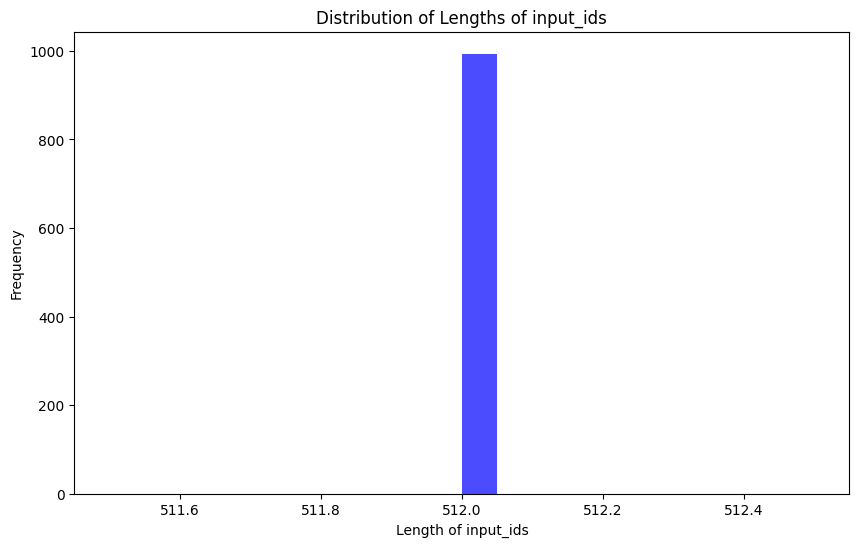

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [17]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4

In [18]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [19]:
import torch

# Print the PyTorch version
print(torch.__version__)

2.2.1+cu121


In [21]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=750,
        learning_rate=2.5e-3, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        #run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,No log,8.527534
100,No log,3.563683
150,No log,2.948319
200,No log,2.987698
250,No log,3.019512
300,No log,2.852117
350,No log,2.595824
400,No log,2.903141
450,No log,2.579238
500,5.354400,2.536238


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=750, training_loss=4.344323486328125, metrics={'train_runtime': 7678.6611, 'train_samples_per_second': 0.195, 'train_steps_per_second': 0.098, 'total_flos': 3.075874883842867e+16, 'train_loss': 4.344323486328125, 'epoch': 3.01})

In [22]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
 , 303333330, 333,: 333., 33,: Open: Open:30333,: Volum

In [24]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
 High:3,: Open: 3,  Open: 33, 300 Open: Open: Open:  Op

In [25]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7B, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama2-7b-journal-finetune/checkpoint-500")

In [27]:
eval_prompt = """ Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

 Given the following financial input data, predict the output data for the closing numbers of that day

### Financial Input Data:
Market Values for previous 6 days:
Day 1: Open:33710.69921875 High:33954.7109375 Low:33582.9609375 Close:33912.44140625 Adj Close:33912.44140625 Volume:262670000,
Day 2: Open:33924.3515625 High:34281.359375 Low:33852.5703125 Close:34152.01171875 Adj Close:34152.01171875 Volume:288670000,
Day 3: Open:34029.55078125 High:34161.01171875 Low:33828.41015625 Close:33980.3203125 Adj Close:33980.3203125 Volume:281390000,
Day 4: Open:33981.859375 High:34043.828125 Low:33844.4609375 Close:33999.0390625 Adj Close:33999.0390625 Volume:282550000,
Day 5: Open:33904.69140625 High:33904.69140625 Low:33627.08984375 Close:33706.73828125 Adj Close:33706.73828125 Volume:293990000,
Day 6: Open:33586.58984375 High:33586.58984375 Low:33007.62890625 Close:33063.609375 Adj Close:33063.609375 Volume:308900000."

### Output Data:
0 Open: Ad: 330, 3,j: Open:3 Open: Open: Ad: Ad: Open: 